In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_recall_curve, average_precision_score
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import ADASYN
import tensorflow as tf
from tensorflow.keras.models import Sequential, clone_model
from tensorflow.keras.layers import Dense, Dropout, Input, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.isotonic import IsotonicRegression
from collections import Counter
import tensorflow.keras.backend as K
import scipy.stats as stats

In [2]:
# ---------------------------
# 1. Data loading and extended feature engineering
# ---------------------------

data = pd.read_csv('machine_downtimes_data.csv')
print(data.head())
print("\nDistribution of failures in the data:")
print(data['failure'].value_counts())

data['prod_units'] = data['production_time'] * data['units_produced']
data['temp_hum_ratio'] = data['temperature'] / data['humidity']
data['prod_time_sq'] = data['production_time'] ** 2
data['machine_age_sq'] = data['machine_age'] ** 2
data['interaction_temp_age'] = data['temperature'] * data['machine_age']

data['log_prod_time'] = np.log(data['production_time'] + 1)
data['log_units'] = np.log(data['units_produced'] + 1)
data['log_machine_age'] = np.log(data['machine_age'] + 1)

   production_time  units_produced  temperature   humidity  machine_age  \
0        64.967142              46    74.587290  52.532250     6.673973   
1        58.617357              43    71.845860  68.606396     6.780374   
2        66.476885              51    75.576226  52.929368     1.544063   
3        75.230299              45    80.693222  49.683483     1.321464   
4        57.658466              53    79.485500  43.537294     9.381849   

   failure   prod_units  temp_hum_ratio  prod_time_sq  machine_age_sq  \
0        0  2988.488510        1.419838   4220.729479       44.541915   
1        0  2520.546350        1.047218   3435.994540       45.973469   
2        0  3390.321154        1.427869   4419.176290        2.384129   
3        0  3385.363435        1.624146   5659.597822        1.746267   
4        0  3055.898711        1.825688   3324.498731       88.019085   

   interaction_temp_age  log_prod_time  log_units  log_machine_age  
0            497.793551       4.189157   

In [3]:
# ---------------------------
# 2. Data partitioning, normalisation and selective oversampling for ‘smaller’ features
# ---------------------------
features = data.drop('failure', axis=1)
target = data['failure']

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=42)
print("\nRozkład klas przed oversampling:")
print(y_train.value_counts())

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

median_pt = np.median(X_train_scaled[:, 0])
median_units = np.median(X_train_scaled[:, 1])

mask_small = (X_train_scaled[:, 0] < median_pt) & (X_train_scaled[:, 1] < median_units)
X_train_small = X_train_scaled[mask_small]
y_train_small = y_train[mask_small]

mask_large = ~mask_small
X_train_large = X_train_scaled[mask_large]
y_train_large = y_train[mask_small == False]

print("\nNumber of observations in a subset of ‘minor features’:", X_train_small.shape[0])
print("Number of observations in the ‘larger features’ subset:", X_train_large.shape[0])

adasyn = ADASYN(random_state=42)
X_train_small_res, y_train_small_res = adasyn.fit_resample(X_train_small, y_train_small)
print("\nClass distribution in a subset of ‘smaller features’ after oversampling:")
print(pd.Series(y_train_small_res).value_counts())

X_train_combined = np.vstack([X_train_large, X_train_small_res])
y_train_combined = np.concatenate([y_train_large, y_train_small_res])
print("\nTotal number of post-merger observations:", X_train_combined.shape[0])
print("Post-merger class distribution:")
print(pd.Series(y_train_combined).value_counts())

counter = Counter(y_train_combined)
class_weight = {0: 1.0, 1: counter[0] / counter[1]}
print("\nClass weights:", class_weight)


Rozkład klas przed oversampling:
failure
0    64311
1     5689
Name: count, dtype: int64

Number of observations in a subset of ‘minor features’: 16893
Number of observations in the ‘larger features’ subset: 53107

Class distribution in a subset of ‘smaller features’ after oversampling:
failure
1    14777
0    14587
Name: count, dtype: int64

Total number of post-merger observations: 82471
Post-merger class distribution:
0    64311
1    18160
Name: count, dtype: int64

Class weights: {0: 1.0, 1: 3.5413546255506607}


In [4]:
# ---------------------------
# 3. Definition of the weighted loss function Binary Crossentropy
# ---------------------------
def weighted_binary_crossentropy(y_true, y_pred):
    w0 = 1.0
    w1 = class_weight[1]
    y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
    loss = - (w1 * y_true * K.log(y_pred) + w0 * (1 - y_true) * K.log(1 - y_pred))
    return K.mean(loss)

In [5]:
# ---------------------------
# 4. Building team models
# ---------------------------
def create_model_1(input_dim):
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss=weighted_binary_crossentropy, metrics=['accuracy'])
    return model

def create_model_2(input_dim):
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(32, activation='relu'),
        BatchNormalization(),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss=weighted_binary_crossentropy, metrics=['accuracy'])
    return model

input_dim = X_train_combined.shape[1]
model1 = create_model_1(input_dim)
model2 = create_model_2(input_dim)

model1.summary()
model2.summary()

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)

history1 = model1.fit(
    X_train_combined, y_train_combined,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[early_stop, reduce_lr],
    verbose=1,
    class_weight=class_weight
)

history2 = model2.fit(
    X_train_combined, y_train_combined,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[early_stop, reduce_lr],
    verbose=1,
    class_weight=class_weight
)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,161 (47.50 KB)

 Trainable params: 12,161 (47.50 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 128)            │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,057 (51.00 KB)

 Trainable params: 12,609 (49.25 KB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/100
2062/2062 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8991 - loss: 0.7347 - val_accuracy: 0.4067 - val_loss: 2.6586 - learning_rate: 0.0010
Epoch 2/100
2062/2062 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9004 - loss: 0.7081 - val_accuracy: 0.3661 - val_loss: 2.8528 - learning_rate: 0.0010
Epoch 3/100
2062/2062 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9005 - loss: 0.7115 - val_accuracy: 0.4028 - val_loss: 2.6754 - learning_rate: 0.0010
Epoch 4/100
2062/2062 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8956 - loss: 0.7250 - val_accuracy: 0.3551 - val_loss: 2.9649 - learning_rate: 0.0010
Epoch 5/100
2062/2062 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8995 - loss: 0.7195 - val_accuracy: 0.3836 - val_loss: 2.8544 - learning_rate: 0.0010
Epoch 6/100
2048/2062 ━━━━━━━━━━━━━━━━━━━━ 0s 888us/step - accuracy: 0.9025 - loss: 0.7029
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
2062/2062 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9

In [7]:
# ---------------------------
# 5. Ensemble - averaging the predictions of both models
# ---------------------------
y_probs1 = model1.predict(X_test_scaled).ravel()
y_probs2 = model2.predict(X_test_scaled).ravel()
y_probs_ensemble = (y_probs1 + y_probs2) / 2

938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 403us/step
938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 458us/step


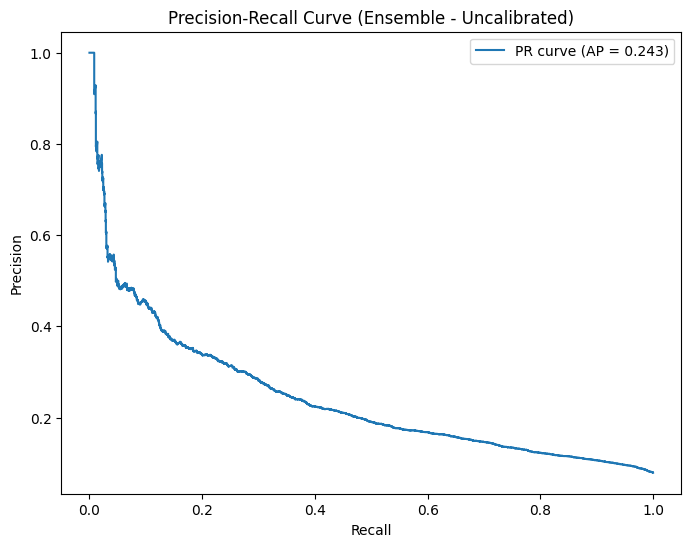

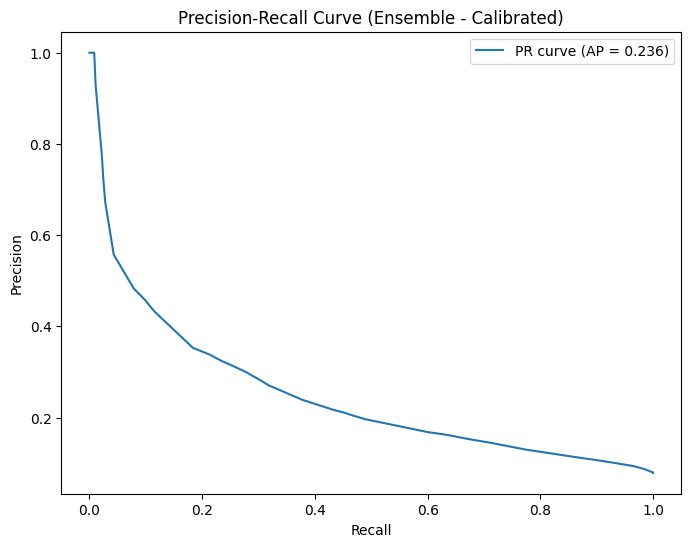


Evaluation of different thresholds (Calibrated Ensemble):
Threshold: 0.1  F1-score: 0.259
Threshold: 0.2  F1-score: 0.288
Threshold: 0.3  F1-score: 0.183
Threshold: 0.4  F1-score: 0.135
Threshold: 0.5  F1-score: 0.043
Threshold: 0.6  F1-score: 0.043
Threshold: 0.7  F1-score: 0.022
Threshold: 0.8  F1-score: 0.017
Threshold: 0.9  F1-score: 0.017

Optimum threshold: 0.2 z F1-score: 0.288

Classification Report (Calibrated Ensemble, threshold 0.2):
              precision    recall  f1-score   support

           0       0.94      0.94      0.94     27630
           1       0.30      0.28      0.29      2370

    accuracy                           0.89     30000
   macro avg       0.62      0.61      0.61     30000
weighted avg       0.89      0.89      0.89     30000

Confusion matrix:
[[26094  1536]
 [ 1712   658]]


In [8]:
# ---------------------------
# 6. Calibration and optimisation of the decision threshold
# ---------------------------
prec, rec, _ = precision_recall_curve(y_test, y_probs_ensemble)
ap_score = average_precision_score(y_test, y_probs_ensemble)
plt.figure(figsize=(8, 6))
plt.plot(rec, prec, label=f'PR curve (AP = {ap_score:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (Ensemble - Uncalibrated)')
plt.legend()
plt.show()

calibrator = IsotonicRegression(out_of_bounds='clip')
calibrator.fit(y_probs_ensemble, y_test)
y_probs_calibrated = calibrator.predict(y_probs_ensemble)

prec_cal, rec_cal, _ = precision_recall_curve(y_test, y_probs_calibrated)
ap_score_cal = average_precision_score(y_test, y_probs_calibrated)
plt.figure(figsize=(8, 6))
plt.plot(rec_cal, prec_cal, label=f'PR curve (AP = {ap_score_cal:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (Ensemble - Calibrated)')
plt.legend()
plt.show()

thresholds = np.arange(0.1, 1.0, 0.1)
best_threshold = 0.5
best_f1 = 0.0

print("\nEvaluation of different thresholds (Calibrated Ensemble):")
for t in thresholds:
    y_pred_t = (y_probs_calibrated >= t).astype(int)
    f1 = f1_score(y_test, y_pred_t, pos_label=1)
    print("Threshold: {:.1f}  F1-score: {:.3f}".format(t, f1))
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = t

print("\nOptimum threshold: {:.1f} z F1-score: {:.3f}".format(best_threshold, best_f1))
y_pred_adjusted = (y_probs_calibrated >= best_threshold).astype(int)

print("\nClassification Report (Calibrated Ensemble, threshold {:.1f}):".format(best_threshold))
print(classification_report(y_test, y_pred_adjusted))
print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred_adjusted))

The code below calculates for each observation the probability of failure using the calculate_failure_probability function, then selects the 10% of observations with the lowest probability of failure. For the selected group, for each of the key parameters (e.g. production_time, units_produced, temperature, humidity, machine_age) we fit a normal distribution (using a function from the scipy.stats package) and visualise a histogram together with a density curve. You can of course modify the percentage or list of parameters as required.

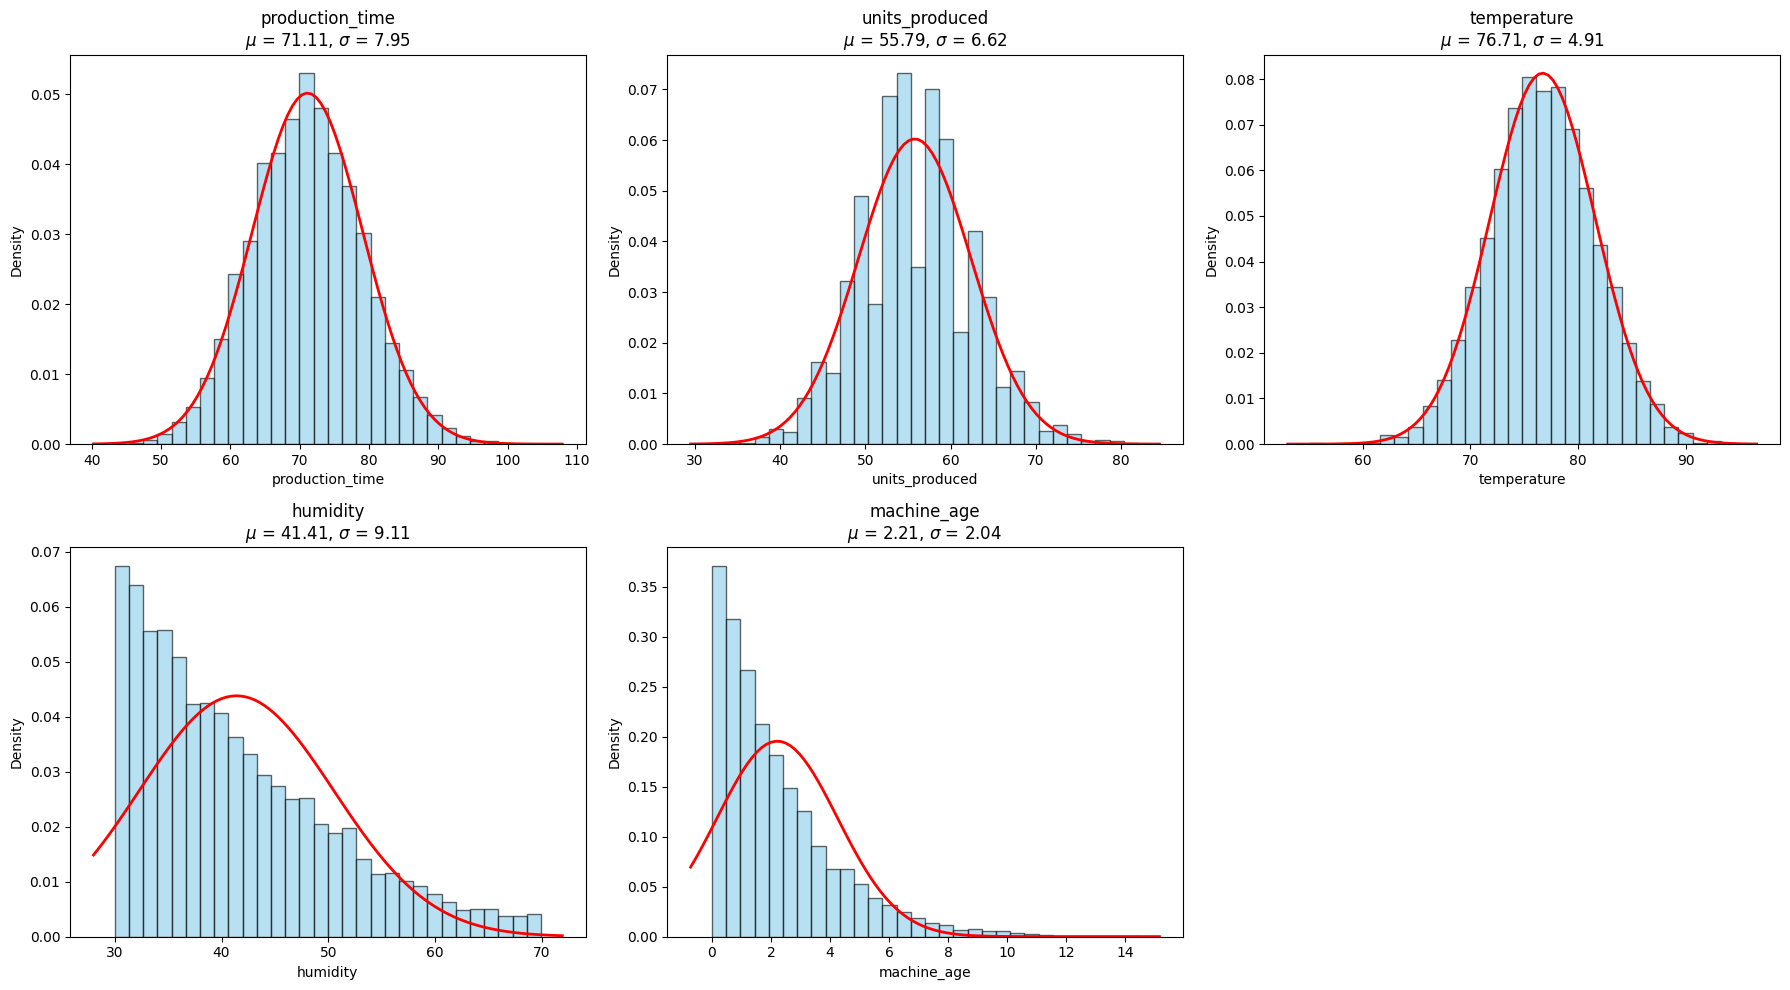

In [12]:
def calculate_failure_probability(pt, up, temp, hum, age):
    coef_pt = -0.05    # higher production_time reduces risk
    coef_up = -0.05    # the higher number of units produced reduces the risk
    coef_temp = -0.03  # higher temperatures reduce the risk
    coef_hum = 0.03    # higher humidity increases the risk
    coef_age = 0.1     # an older machine increases the risk
    intercept = 3.0
    logit = intercept + coef_pt * pt + coef_up * up + coef_temp * temp + coef_hum * hum + coef_age * age
    prob = 1 / (1 + np.exp(-logit))
    return prob

data = pd.read_csv('machine_downtimes_data.csv')

data['failure_prob'] = calculate_failure_probability(
    data['production_time'],
    data['units_produced'],
    data['temperature'],
    data['humidity'],
    data['machine_age']
)

threshold = np.percentile(data['failure_prob'], 10)
low_failure = data[data['failure_prob'] <= threshold]

parameters = ['production_time', 'units_produced', 'temperature', 'humidity', 'machine_age']

fig, axs = plt.subplots(2, 3, figsize=(18, 10))
axs = axs.flatten()

for i, param in enumerate(parameters):
    ax = axs[i]
    param_data = low_failure[param]
    mu, std = stats.norm.fit(param_data)
    ax.hist(param_data, bins=30, density=True, alpha=0.6, color='skyblue', edgecolor='black')
    xmin, xmax = ax.get_xlim()
    x = np.linspace(xmin, xmax, 100)
    p = stats.norm.pdf(x, mu, std)
    ax.plot(x, p, 'r', linewidth=2)
    ax.set_title(f'{param}\n$\\mu$ = {mu:.2f}, $\\sigma$ = {std:.2f}')
    ax.set_xlabel(param)
    ax.set_ylabel('Density')

for j in range(i+1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

What is the result of this in practice?

production_time (μ = 71.1, σ = 7.55): Machines with a low probability of failure have production times clustered around about 71 units (e.g. minutes), with a typical deviation of about 7.55.

units_produced (μ = 57.0, σ = 6.62): The least failing machines produce an average of 57 units (with a standard deviation of 6.62).

temperature (μ = 70.1, σ = 4.91): For machines with a low risk of failure, the temperature stays around 70 degrees (with a deviation of about 5 degrees).

The graphs shown show histograms (bars) for two parameters - humidity (humidity) and machine age (machine_age) - in the group of machines with the lowest probability of failure. The red line is the fitted normal distribution curve with calculated mean (μμ) and standard deviation (σσ).

Humidity

    The mean (μμ) is approximately 41.41 and the standard deviation (σσ) is 9.11.
    The histogram suggests that humidity among these low-failure machines is most often in the region of 30-50, although it also reaches around 70.
    The distribution has a slightly ‘right tail’ (elongation on the right), as can be seen by the fact that values occur up to 70, but less frequently.

Machine age (machine_age)

    The mean (μμ) is approximately 2.21 and the standard deviation (σσ) is 2.04.
    The data clearly cluster closer to 0-2 years, and the older the machine, the fewer observations in this ‘low failure’ group.
    The histogram has a strong shift to the right (so-called rightward skewness), which often suggests that the normal distribution does not perfectly represent the true shape (distributions with a long tail to the right, e.g. close to exponential, are more typical for machine age).

How to interpret this?

    The average values tell you in which range the measurements most often fall among machines with a low risk of failure:
        Humidity around 40-50%.
        Machine age usually around 2 years (with a fairly wide dispersion).

    The standard deviation (σ) shows how widely the data are dispersed around the mean.
        For moisture content (σ ~ 9) means that values quite often can be both below 35% and above 45%.
        For age (σ ~ 2), it indicates that some of the machines in this group can be less than a year old and some as old as 4-5 years, although the older they are, the less often they end up in this ‘low failure’ group.

    Shape of the histogram:
        If the histogram is clearly skewed (as with machine_age), the normal distribution curve will only be an approximation.
        In the case of humidity, although there is also some skewness, the distribution is more ‘bell-shaped’ than for machine age.

In practice, this means that younger machines predominate among the machines with the lowest risk of failure (which is not surprising, as the age of the machine increases the probability of failure), and also the moisture content remains in moderate ranges (with a tendency towards values around 40-50%).

